#### Model Training

##### 1.1 Import Data and Required Packages

Importing Libraries.

In [290]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling evaluation
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Import the CSV Data as Pandas DataFrame


In [291]:
df = pd.read_csv('diabetes-2-1.csv')

Show Top 5 Records

In [292]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Check Outliers

In [293]:
# Create list of features_to_scale_robust
features_to_scale_robust = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

# Function to count outliers and remove them from the dataframe
def count_outliers(feature, df):
    # Calculate the quartiles and interquartile range (IQR)
    Q1 = feature.quantile(0.25)
    Q3 = feature.quantile(0.75)
    IQR = Q3 - Q1
    # Calculate the lower and upper bounds for outliers detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter the dataframe to remove outliers based on the calculated bounds
    df_without_outlier = df[~((feature < lower_bound) | (feature > upper_bound))]
    # Count the number of outliers
    num_outliers = ((feature < lower_bound) | (feature > upper_bound)).sum()
    return num_outliers, df_without_outlier

df_cleaned = df.copy()  # Create a copy of the original dataframe

total_outliers_deleted = 0  # Initialize variable to store the total number of deleted outliers

# Iterate through each feature
for feature in features_to_scale_robust:
    # Call count_outliers function to count outliers and get cleaned dataframe
    num_outliers, df_cleaned = count_outliers(df[feature], df_cleaned)
    print(f'Number of outliers in {feature}: {num_outliers}')  # Print the number of outliers for each feature
    total_outliers_deleted += num_outliers  # Add the number of outliers deleted for each feature

Number of outliers in Pregnancies: 4
Number of outliers in Glucose: 5
Number of outliers in BloodPressure: 45
Number of outliers in SkinThickness: 1
Number of outliers in Insulin: 34
Number of outliers in BMI: 19
Number of outliers in DiabetesPedigreeFunction: 29
Number of outliers in Age: 9


C:\Users\abdu\AppData\Local\Temp\ipykernel_3328\3518368000.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_without_outlier = df[~((feature < lower_bound) | (feature > upper_bound))]
C:\Users\abdu\AppData\Local\Temp\ipykernel_3328\3518368000.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_without_outlier = df[~((feature < lower_bound) | (feature > upper_bound))]
C:\Users\abdu\AppData\Local\Temp\ipykernel_3328\3518368000.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_without_outlier = df[~((feature < lower_bound) | (feature > upper_bound))]
C:\Users\abdu\AppData\Local\Temp\ipykernel_3328\3518368000.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_without_outlier = df[~((feature < lower_bound) | (feature > upper_bound))]
C:\Users\abdu\AppData\Local\Temp\ipykernel_3328\3518368000.py:15: UserWarning: Boolean Series key will be reinde

In [294]:
#check the total number of deleted outliers
print("Total number of deleted outliers is:", total_outliers_deleted)

Total number of deleted outliers is: 146


What have we done?

In [295]:
#Check the amount of daibetic in df before dropping outliers
print ('The amount of daibetic cases in df before dropping outliers: ', len(df[df['Outcome'] == 1]))
#Check the amount of daibetic in df after dropping outliers
print ('The amount of daibetic cases in df after dropping outliers: ', len(df_cleaned[df_cleaned['Outcome'] == 1]))

#Check the amount of non-daibetic in df before dropping outliers
print ('The amount of daibetic cases in df before dropping outliers: ', len(df[df['Outcome'] == 1]))
#Check the amount of non-daibetic in df after dropping outliers
print ('The amount of daibetic cases in df after dropping outliers: ', len(df_cleaned[df_cleaned['Outcome'] == 1]))

The amount of daibetic cases in df before dropping outliers:  268
The amount of daibetic cases in df after dropping outliers:  200
The amount of daibetic cases in df before dropping outliers:  268
The amount of daibetic cases in df after dropping outliers:  200


By deleting outliers we dropped about 25% of the very important data! We shouldn't do that!

We have a few options here, but for that study we will just come back to the stage just before dropping outliers. 

Replace the Zeros Values

In [296]:
# Create an instance of SimpleImputer with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Define the columns you want to impute
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zero values with NaN
df.loc[:, columns_to_impute] = df[columns_to_impute].replace(0, np.nan)


# Fit the imputer on the columns with missing values
imputer.fit(df[columns_to_impute])

# Transform the DataFrame by imputing missing values
df[columns_to_impute] = imputer.transform(df[columns_to_impute])

In [297]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Preparing X and Y variables

In [298]:
# independent and dependent features
X = df.drop('Outcome',axis=1) #df.iloc[:,:-1]
y = df['Outcome'] # df.iloc[:,-1]

Train Test split

In [299]:
# Importing the train_test_split function from sklearn.model_selection module
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
# X: Features, y: Target variable
# test_size=0.2 indicates that 20% of the data will be used for testing, while 80% will be used for training
# random_state=0 sets a random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Printing the shapes of the original features, and the training and testing sets
print(X.shape, X_test.shape, X_train.shape)

(768, 8) (154, 8) (614, 8)


Data Standarization

In [300]:
# Importing the StandardScaler class from the sklearn.preprocessing module
from sklearn.preprocessing import StandardScaler

# Creating a StandardScaler object
scaler = StandardScaler()

# Standardizing the features in the training set (X_train)
# fit_transform() method calculates the mean and standard deviation of each feature in X_train
# and then standardizes the features by subtracting the mean and dividing by the standard deviation
X_train = scaler.fit_transform(X_train)

# Standardizing the features in the testing set (X_test)
# transform() method uses the mean and standard deviation calculated from X_train to standardize X_test
# This ensures that both training and testing sets are standardized using the same scaling parameters
X_test = scaler.transform(X_test)


#### Training the Models

1. Logistic Regression

In [301]:
# Importing the LogisticRegression class from the sklearn.linear_model module
from sklearn.linear_model import LogisticRegression

# Creating a LogisticRegression object
lr = LogisticRegression()
# Train the model on the training data
lr.fit(X_train,y_train)

LogisticRegression()

2. Support Vector Machine SVM

In [302]:
# Importing the SVC (Support Vector Classifier) class from the sklearn.svm module
from sklearn.svm import SVC

# Creating an SVC object
svm = SVC(probability=True)
# Train the model on the training data
svm.fit(X_train,y_train)

SVC(probability=True)

3. K Nearest Neighbors


In [303]:
# Importing the KNeighborsClassifier class from the sklearn.neighbors module
from sklearn.neighbors import KNeighborsClassifier

# Creating a KNeighborsClassifier object
knn = KNeighborsClassifier()
# Train the model on the training data
knn.fit(X_train,y_train)

KNeighborsClassifier()

4. Gradient Boosting 

In [304]:
# Importing the GradientBoostingClassifier class from the sklearn.ensemble
from sklearn.ensemble import GradientBoostingClassifier

# Initialize a Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the training data
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

5. Decision Tree

In [305]:
# Importing the DecisionTreeClassifier class from the sklearn.tree module
from sklearn.tree import DecisionTreeClassifier

# Creating a DecisionTreeClassifier object
dt = DecisionTreeClassifier()
#Fit The model
dt.fit(X_train,y_train)

DecisionTreeClassifier()

6. Random Forest

In [306]:
# Importing the RandomForestClassifier class from the sklearn.ensemble module
from sklearn.ensemble import RandomForestClassifier

# Creating a RandomForestClassifier object
rf = RandomForestClassifier()
#Fit The model
rf.fit(X_train,y_train)

RandomForestClassifier()

Models objects and names

In [307]:
# Define models list
models = [lr, knn, gb, svm, dt, rf]
# List of model names
models_names = ["Logistic Regression", "K-Nearest Neighbors", "Gradient Boosting", "Support Vector Machine", "Decision Tree", "Random Forest"]

### Assess the complexity of each model

In [308]:
def assess_model_complexity(model):
    num_parameters = model._get_param_names()  # Get the names of the parameters
    computational_complexity = "High" if hasattr(model, "decision_function") else "Low"  # Check if the model has a decision function
    interpretability = "High" if hasattr(model, "feature_importances_") else "Low"  # Check if the model has feature importances
    return num_parameters, computational_complexity, interpretability

In [309]:
# Initialize an empty list to store the rows of the table
table_data = []

# Populate the table data with the complexity assessment for each model
for model, model_name in zip(models, models_names):
    num_parameters, computational_complexity, interpretability = assess_model_complexity(model)
    table_data.append([model_name, len(num_parameters), computational_complexity, interpretability])

# Define the headers for the table
headers = ["Model", "Num Parameters", "Computational Complexity", "Interpretability"]

# Convert the table data to a DataFrame
df = pd.DataFrame(table_data, columns=headers)

# Print the DataFrame
display(df)


,Model,Num Parameters,Computational Complexity,Interpretability
0,Logistic Regression,15,High,Low
1,K-Nearest Neighbors,8,Low,Low
2,Gradient Boosting,20,High,High
3,Support Vector Machine,15,High,Low
4,Decision Tree,12,Low,High
5,Random Forest,18,Low,High


#### Plot Feature Importance

In [310]:
# Define a function to plot feature importance
def plot_feature_importance(model, feature_names, ax=None):
    # Get feature importances and sort them
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot feature importance
    ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([feature_names[i] for i in sorted_idx])
    ax.set_xlabel('Importance')
    ax.set_title('Feature Importance')

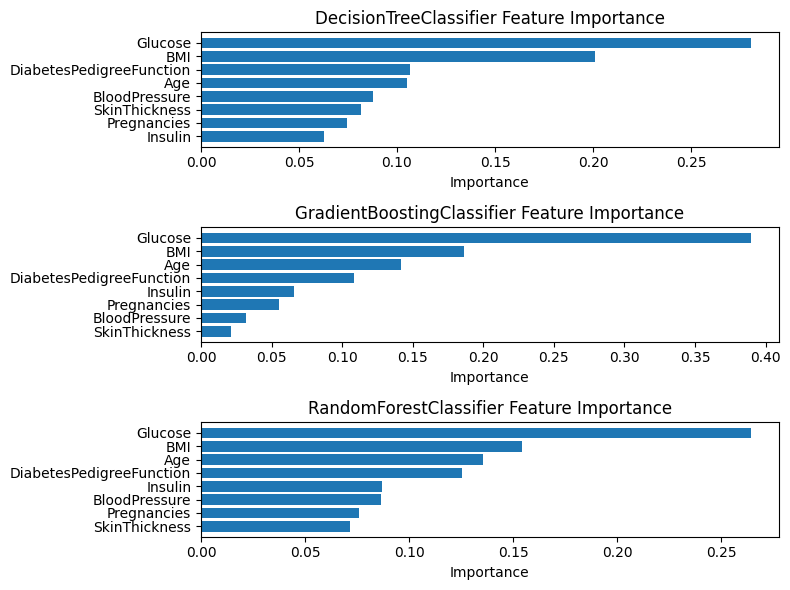

In [311]:
# Plot visualizations for each model
feature_importance_models = [dt,gb,rf]  # Assuming these are your trained models

# Define the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(feature_importance_models):
       plot_feature_importance(model, X.columns, ax=axes[i])
       axes[i].set_title(f"{model.__class__.__name__} Feature Importance")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

#### Plot Learning Curve

In [312]:
# Import necessary functions/classes from sklearn
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X_train, y_train, cv=None, n_jobs=-1, ax=None):
    # Generate learning curves using learning_curve function
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=cv, n_jobs=n_jobs)
    # Compute mean and standard deviation of training scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    # Compute mean and standard deviation of test scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Fill the area between the training score curves
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    # Fill the area between the test score curves
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    # Plot the training score curve
    ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    # Plot the cross-validation score curve
    ax.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    # Set title of the plot
    ax.set_title(title)
    # Set label for x-axis
    ax.set_xlabel("Training examples")
    # Set label for y-axis
    ax.set_ylabel("Score")
    # Add legend to the plot
    ax.legend(loc="best")


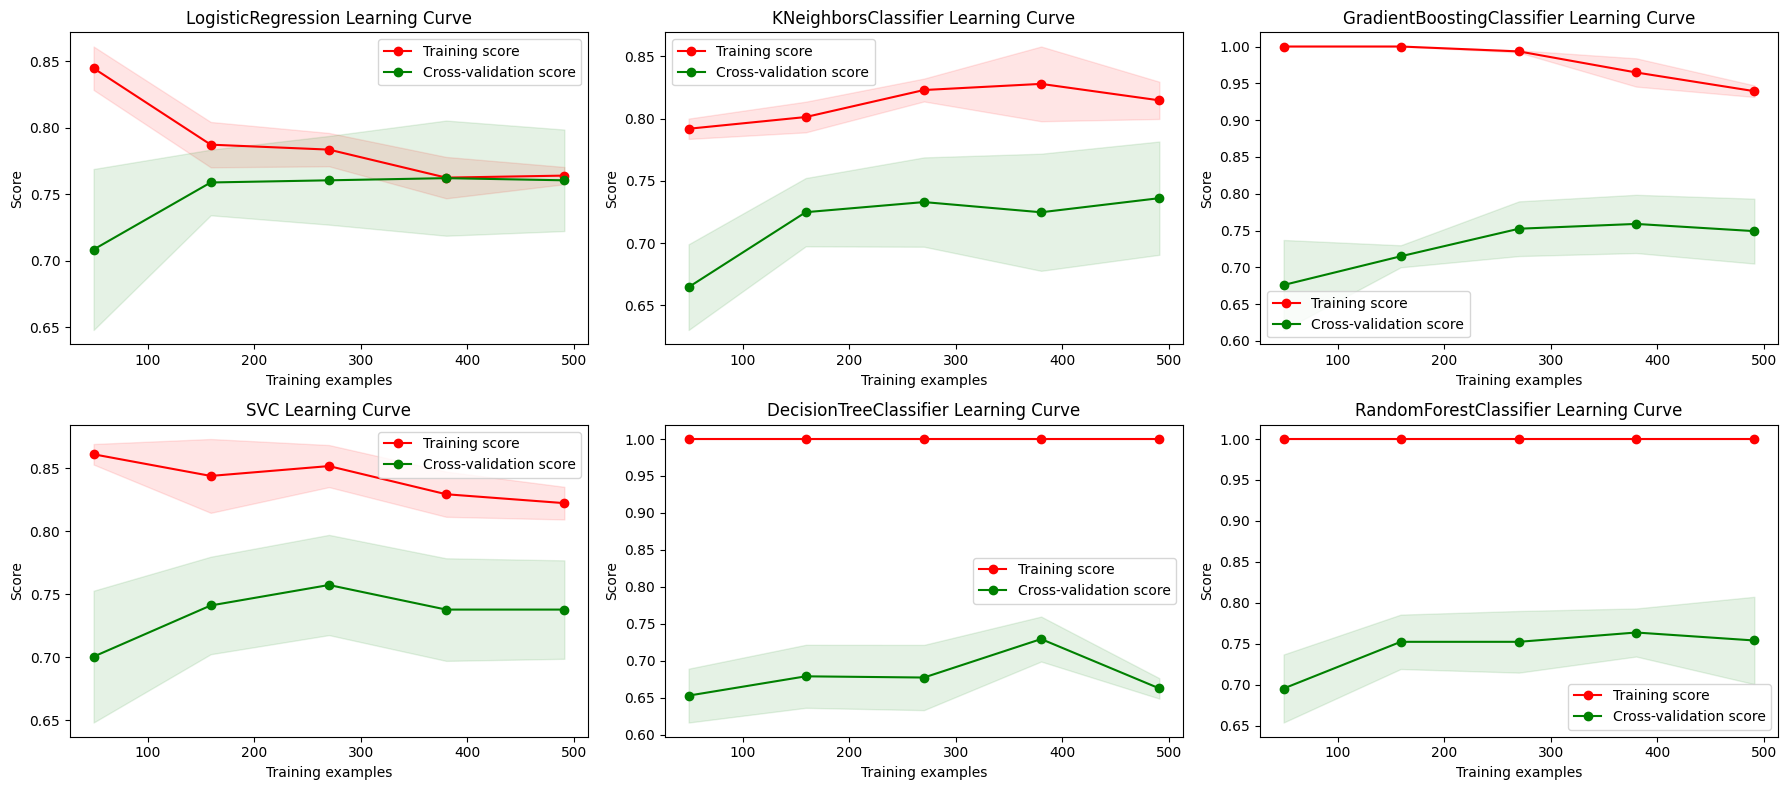

In [313]:
# Define the layout of the grid
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 8))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(models):
    plot_learning_curve(model, f"{model.__class__.__name__} Learning Curve", X_train, y_train, cv=5, ax=axes[i])

    # Set title for each subplot
    axes[i].set_title(f"{model.__class__.__name__} Learning Curve")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Evaluation Metrics
#### Confusion Matrix, accuracy, precision, recall, f1 score

In [314]:
from sklearn.metrics import confusion_matrix

# Define a function to compute specificity
def specificity_score(y_true, y_pred):
    # Compute confusion matrix and unpack values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Compute specificity 
    specificity = tn / (tn + fp)
    return specificity

# Define a function to compute evaluation metrics for all models
def evaluate_all_models(models, X_test, y_test):
    # Define lists to store evaluation metrics for test sets
    models_confusion_matrix = []
    models_metrics = []

    # Loop through each model
    for model in models:
        # Compute evaluation metrics for the model
        model_metrics = compute_evaluation_metrics(model, X_test, y_test)
        
        # Append insights to the respective lists
        models_metrics.append(model_metrics)

    # Create DataFrame for test sets
    models_metrics_df = pd.DataFrame(models_metrics)

    # Select columns for the Confusion matrix DataFrame
    cm_columns_to_select = ["Model", "Confusion Matrix", "TP", "FP", "TN", "FN"]

    # Select columns for the metrics DataFrame
    metrics_columns_to_select = ["Model", "Accuracy", "Precision", "Recall/sensitivity", "Specificity", "F1-score"]

    return models_metrics_df[cm_columns_to_select], models_metrics_df[metrics_columns_to_select]

# Define a function to compute evaluation metrics for a single model
def compute_evaluation_metrics(model, X_test, y_test):
    # Predict on test set
    y_pred = model.predict(X_test)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Extract TP, FP, TN, FN from confusion matrix
    tn, fp, fn, tp = cm.ravel()  # Extract values from confusion matrix
    
    # Compute evaluation metrics for test set
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = specificity_score(y_test, y_pred)  # Calculate specificity
    f_score = f1_score(y_test, y_pred)
    
    # Store confusion matrix and metrics df
    metrics = {
        "Model": model.__class__.__name__,
        "Confusion Matrix": cm,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall/sensitivity": recall,
        "Specificity": specificity,
        "F1-score": f_score,
       
    }
    
    return metrics



Plot Confusion Meatrix

In [315]:
from sklearn.metrics import confusion_matrix

# Define a function to plot confusion matrix for all the models
def plot_confusion_matrix(models_names, models_cm):
    
    # Plot confusion matrices for each model in a grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots
    for i, title in enumerate(models_names):  # Iterate over models
        row = i // 3  # Calculate row index
        col = i % 3  # Calculate column index
        ax = axes[row, col]
        # Plot confusion matrix
        sns.heatmap(models_cm[i], annot=True, fmt='d', cmap='YlGnBu', cbar=False, ax=ax)  # Plot heatmap with annotations
        ax.set_xlabel('Predicted labels')  # Set x-axis label
        ax.set_ylabel('Actual labels')  # Set y-axis label
        ax.set_title(title)  # Set title

    plt.tight_layout()  # Adjust subplot layout to make plots fit into the figure area
    plt.show()  # Show the plots

## Evaluate the models before parameters tuning

In [316]:
# compute evaluation metrics for all models
models_cm_df, models_metrics_df = evaluate_all_models(models, X_test, y_test)

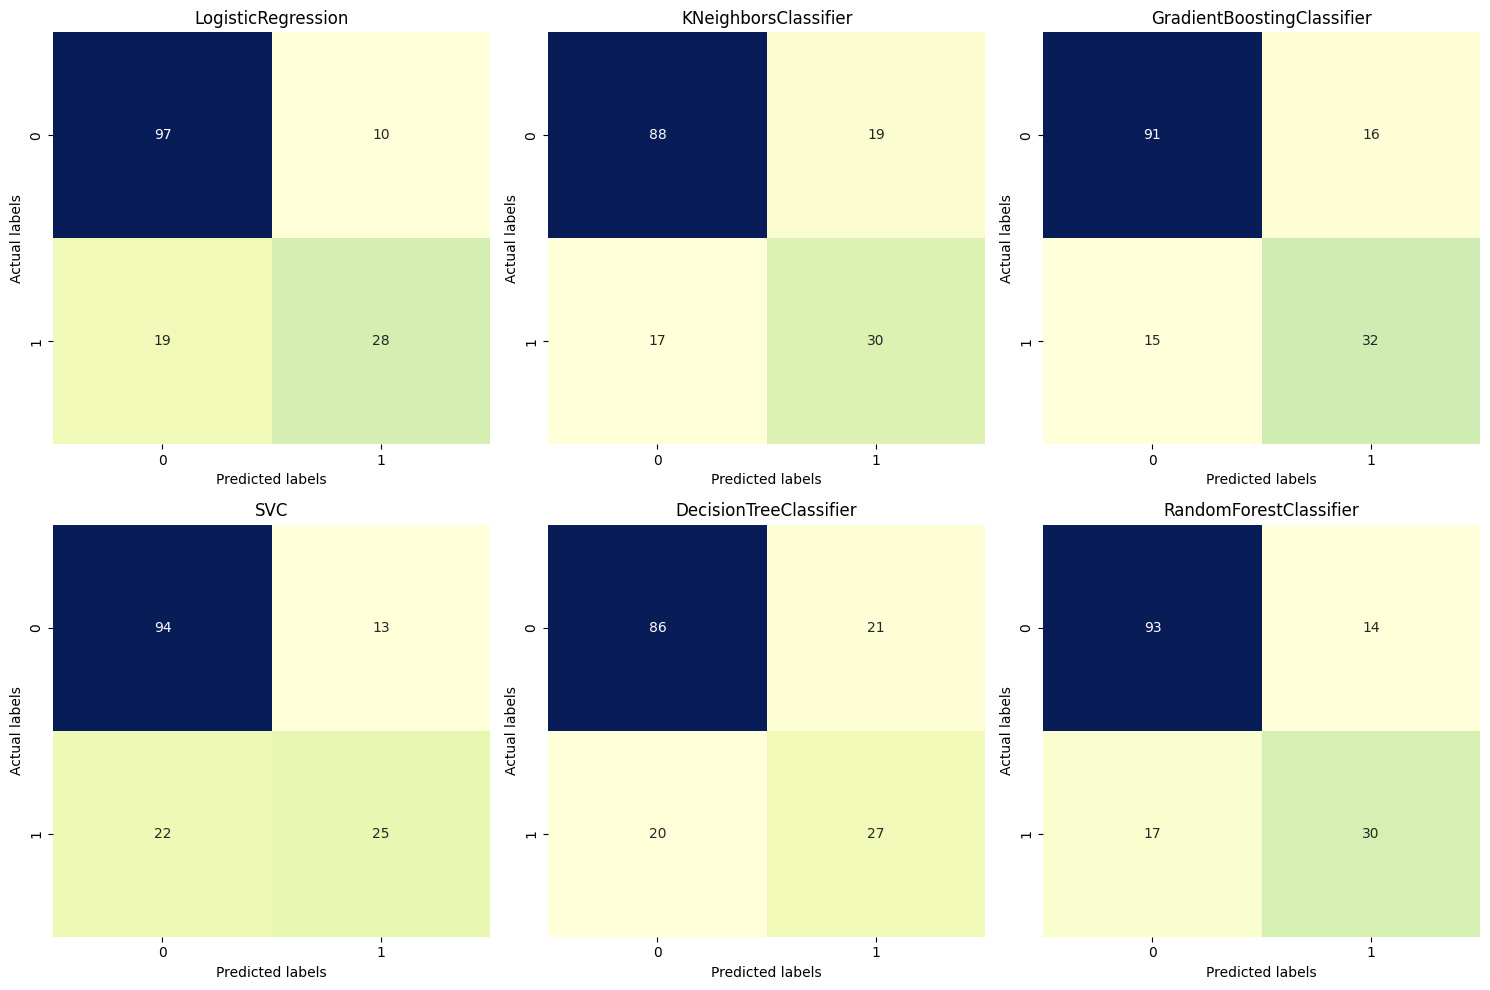

In [317]:
#Plot Confusion Matrix
plot_confusion_matrix(models_cm_df["Model"], models_cm_df["Confusion Matrix"])

In [318]:
# Display the confusion matrix
print("\nConfusion Matrix before tuning:")
display(models_cm_df[["Model", "TP", "FP", "TN", "FN"]])


Confusion Matrix before tuning:


,Model,TP,FP,TN,FN
0,LogisticRegression,28,10,97,19
1,KNeighborsClassifier,30,19,88,17
2,GradientBoostingClassifier,32,16,91,15
3,SVC,25,13,94,22
4,DecisionTreeClassifier,27,21,86,20
5,RandomForestClassifier,30,14,93,17


In each cell, "TP" represents True Positives, "FP" represents False Positives, and "FN" represents False Negatives. "TN" represents True Negatives. These values are filled in for both the diabetic and non-diabetic classes for each model.

In [319]:
# Display the performance metrics DataFrame
print("\nTest Set Evaluation Metrics before tuning:")
display(models_metrics_df)


Test Set Evaluation Metrics before tuning:


,Model,Accuracy,Precision,Recall/sensitivity,Specificity,F1-score
0,LogisticRegression,0.811688,0.736842,0.595745,0.906542,0.658824
1,KNeighborsClassifier,0.766234,0.612245,0.638298,0.822430,0.625000
2,GradientBoostingClassifier,0.798701,0.666667,0.680851,0.850467,0.673684
3,SVC,0.772727,0.657895,0.531915,0.878505,0.588235
4,DecisionTreeClassifier,0.733766,0.562500,0.574468,0.803738,0.568421
5,RandomForestClassifier,0.798701,0.681818,0.638298,0.869159,0.659341


#### Best Parmeters for Models

In [320]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for Logistic Regression model
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter values to test
    'penalty': ['l2']  # Penalty term for regularization ('l2' for ridge regularization)
}

# Define hyperparameter grid for K-Nearest Neighbors (KNN) model
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to consider
    'weights': ['uniform', 'distance']  # Weight function used in prediction
}

# Define the hyperparameter grid for Gradient Boosting model
param_grid_gb = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
    'max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Maximum number of features to consider when splitting a node
}

# Define hyperparameter grid for Support Vector Machine (SVM) model
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel function used for the decision function
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' and 'poly' kernels
}


# Define hyperparameter grid for Decision Tree model
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Maximum number of features to consider when splitting a node
}


# Define hyperparameter grid for Random Forest model
param_grid_rf = {
    'n_estimators': [100, 200,300],  # Number of trees in the forest
    'max_depth': [10,20,30],  # Maximum depth of the trees in the forest
    'min_samples_split': [2, 5,10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2,4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Maximum number of features to consider when splitting a node
}
# Define a list of param_grids corresponding to each model
param_grids = [param_grid_lr, param_grid_knn, param_grid_gb, param_grid_svm, param_grid_dt, param_grid_rf]
# Define scoring functions
scorers = {
    'accuracy_score': make_scorer(accuracy_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score)
}

# Iterate over each model and its corresponding param_grid
for i in range(len(models)):
    model = models[i]  # Get the current model
    param_grid = param_grids[i]  # Get the corresponding hyperparameter grid
    
    
  # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorers, refit='accuracy_score',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
     # Retrieve best parameters and best scores
    best_params = grid_search.best_params_
    best_scores = grid_search.cv_results_

    # Update model with best parameters and fit the model
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    
# Print best parameters and best scores
    print("model after use best parameters: ",model)
    print(f"Best Parameters for {model.__class__.__name__}: {best_params}")
    print(f"Best Scores for {model.__class__.__name__}:")
    for scorer in scorers:
        print(f"{scorer}: {best_scores['mean_test_' + scorer][grid_search.best_index_]}")
    print()

model after use best parameters:  LogisticRegression(C=0.1)
Best Parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
Best Scores for LogisticRegression:
accuracy_score: 0.7622284419565506
precision_score: 0.7177227801689782
recall_score: 0.5573737373737374

model after use best parameters:  KNeighborsClassifier(n_neighbors=9, weights='distance')
Best Parameters for KNeighborsClassifier: {'n_neighbors': 9, 'weights': 'distance'}
Best Scores for KNeighborsClassifier:
accuracy_score: 0.7573770491803279
precision_score: 0.6825200534759358
recall_score: 0.6250505050505051

model after use best parameters:  GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=2,
                           min_samples_split=5, random_state=42)
Best Parameters for GradientBoostingClassifier: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Scores for GradientBoostingClassifier:
accuracy_score: 0.7655071304811408
precision_s

##  Evaluate The models after Parameters tuning

In [321]:
# compute evaluation metrics for all models
models_cm_df, models_metrics_df = evaluate_all_models(models, X_test, y_test)

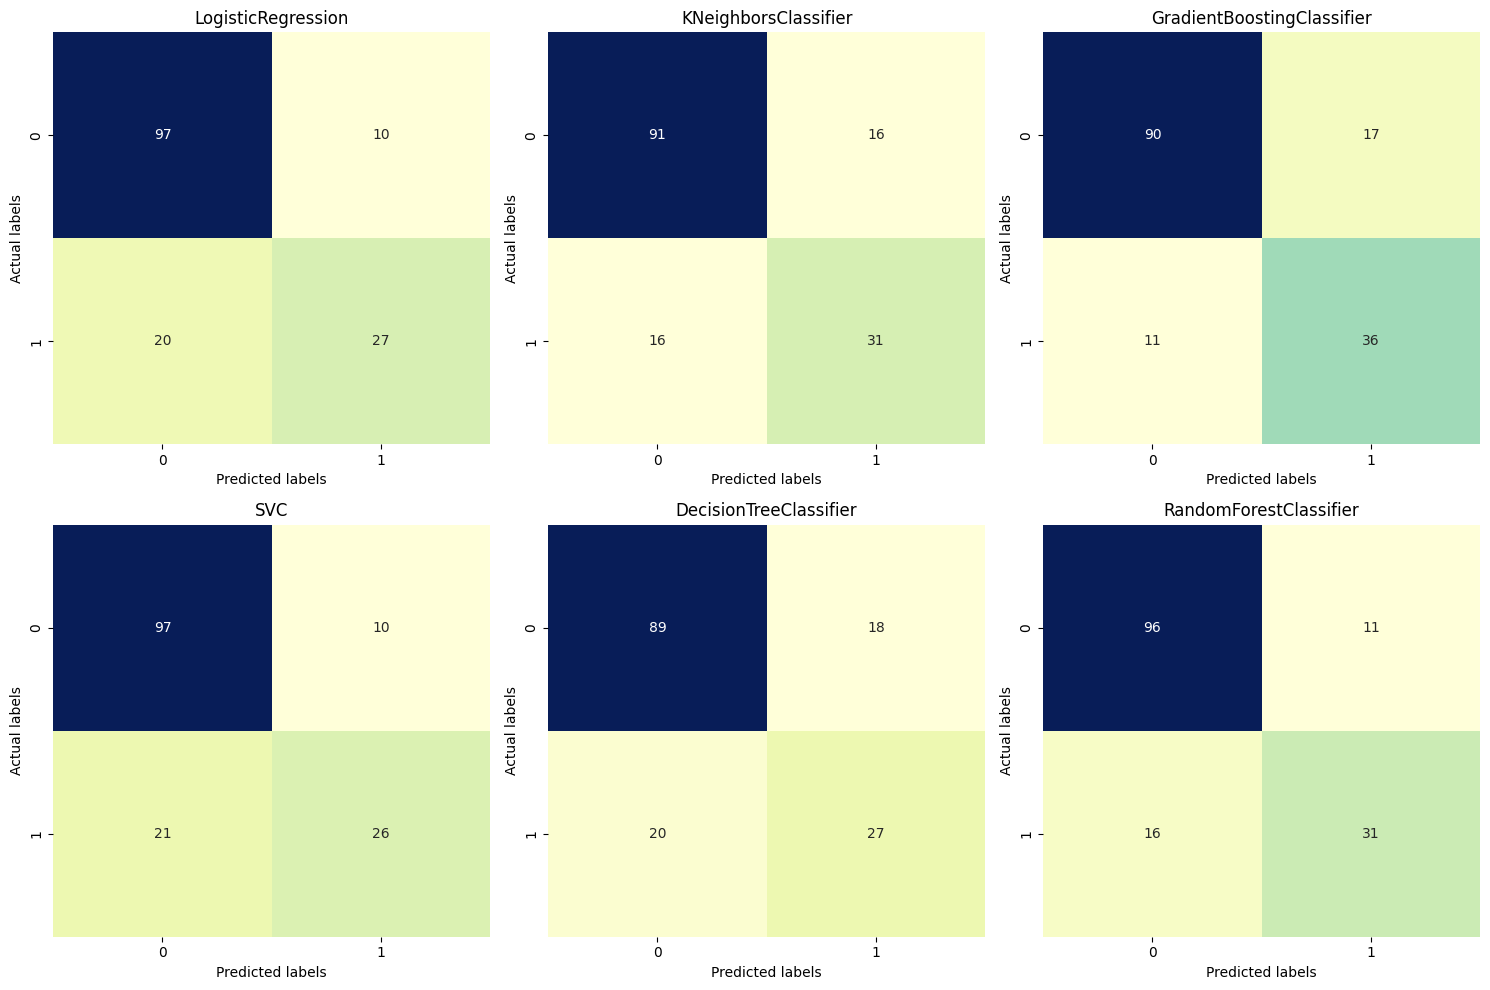

In [322]:
plot_confusion_matrix(models_cm_df["Model"], models_cm_df["Confusion Matrix"])

In [323]:
# Display the confusion matrix
print("\nConfusion Matrix after tuning:")
# display DataFrame
display(models_cm_df[["Model", "TP", "FP", "TN", "FN"]])


Confusion Matrix after tuning:


,Model,TP,FP,TN,FN
0,LogisticRegression,27,10,97,20
1,KNeighborsClassifier,31,16,91,16
2,GradientBoostingClassifier,36,17,90,11
3,SVC,26,10,97,21
4,DecisionTreeClassifier,27,18,89,20
5,RandomForestClassifier,31,11,96,16


In [324]:
# Display the performance metrics DataFrame
print("\nTest Set Evaluation Metrics after tuning:")
display(models_metrics_df)


Test Set Evaluation Metrics after tuning:


,Model,Accuracy,Precision,Recall/sensitivity,Specificity,F1-score
0,LogisticRegression,0.805195,0.729730,0.574468,0.906542,0.642857
1,KNeighborsClassifier,0.792208,0.659574,0.659574,0.850467,0.659574
2,GradientBoostingClassifier,0.818182,0.679245,0.765957,0.841121,0.720000
3,SVC,0.798701,0.722222,0.553191,0.906542,0.626506
4,DecisionTreeClassifier,0.753247,0.600000,0.574468,0.831776,0.586957
5,RandomForestClassifier,0.824675,0.738095,0.659574,0.897196,0.696629


In [325]:
# compute evaluation metrics for all models
models_cm_df, models_metrics_df = evaluate_all_models(models, X_test, y_test)

# Calculate the overall score for each model using a specified equation
for model in models:
    # Retrieve the evaluation metrics for the test set
    metrics = models_metrics_df[models_metrics_df['Model'] == model.__class__.__name__].iloc[0]
    # Calculate the overall score for the model
    score = (metrics['Accuracy']  +  metrics['F1-score']+ metrics['Specificity']) / 3
    # Add the score to the DataFrame
    models_metrics_df.loc[models_metrics_df['Model'] == model.__class__.__name__, 'Score'] = score
print("\nBest Model:")
display(models_metrics_df)
# Find the model with the highest score
best_score = models_metrics_df['Score'].max()
best_model = models_metrics_df[models_metrics_df['Score'] == best_score]
print("\nBest Model:")
display(best_model)


Best Model:


,Model,Accuracy,Precision,Recall/sensitivity,Specificity,F1-score,Score
0,LogisticRegression,0.805195,0.729730,0.574468,0.906542,0.642857,0.784865
1,KNeighborsClassifier,0.792208,0.659574,0.659574,0.850467,0.659574,0.767417
2,GradientBoostingClassifier,0.818182,0.679245,0.765957,0.841121,0.720000,0.793101
3,SVC,0.798701,0.722222,0.553191,0.906542,0.626506,0.777250
4,DecisionTreeClassifier,0.753247,0.600000,0.574468,0.831776,0.586957,0.723993
5,RandomForestClassifier,0.824675,0.738095,0.659574,0.897196,0.696629,0.806167



Best Model:


,Model,Accuracy,Precision,Recall/sensitivity,Specificity,F1-score,Score
5,RandomForestClassifier,0.824675,0.738095,0.659574,0.897196,0.696629,0.806167


#### Plot precision_recall_curve

In [326]:
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, model_name, ax):
    """
    Plot precision and recall scores as a function of the decision threshold.
    
    Parameters:
        precisions (array-like): Precision scores.
        recalls (array-like): Recall scores.
        thresholds (array-like): Decision thresholds.
        model_name (str): Name of the model.
        ax (matplotlib axes): Axes to plot on.
    """
    ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
    ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
    ax.set_ylabel("Score")
    ax.set_xlabel("Decision Threshold")
    ax.set_title(f"Precision and Recall Scores as a Function of Decision Threshold ({model_name})")
    ax.legend(loc='best')



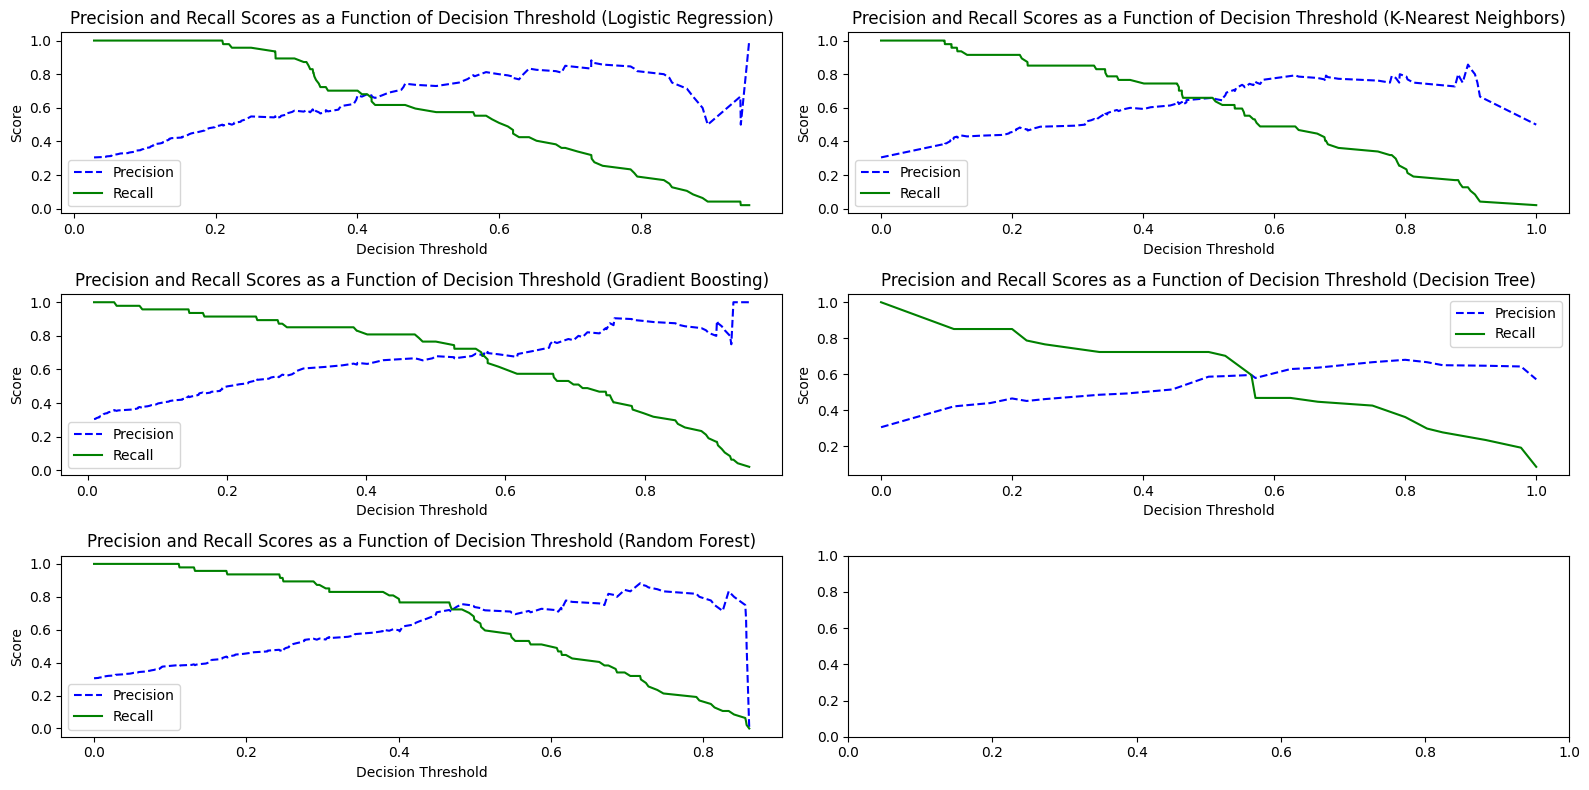

In [327]:
# Define the models
precision_recall_curve_models = [lr, knn, gb, dt, rf]
model_names = ["Logistic Regression", "K-Nearest Neighbors", "Gradient Boosting", "Decision Tree", "Random Forest"]

# Define the number of rows and columns for the grid
num_rows = (len(models) + 1) // 2
num_cols = min(2, len(models))

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

# Flatten the axes if necessary
if num_rows == 1:
    axes = [axes]

# Plot precision-recall curves for each model
for i, (model, name) in enumerate(zip(precision_recall_curve_models, model_names)):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row][col]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Compute precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    
    # Plot precision-recall vs threshold
    plot_precision_recall_vs_threshold(precision, recall, thresholds, name, ax)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [328]:
import numpy as np

def roc_threshold(y_test, y_scores, threshold):
    """
    Modify predicted labels based on the ROC curve threshold.

    Parameters:
        y_test (array-like): True labels for the test set.
        y_scores (array-like): Predicted probabilities for the positive class.
        threshold (float): Threshold value for the ROC curve.

    Returns:
        array-like: Modified predicted labels based on the threshold.
    """
    # Convert probabilities to binary predictions based on the threshold
    y_pred = np.where(y_scores >= threshold, 1, 0)
    
    return y_pred

ROC Curve

In [329]:
# Define a function to plot ROC curve
def plot_roc_curve(model, X_test, y_test, ax=None):
    # Predict probabilities for positive class
    y_score = model.predict_proba(X_test)[:, 1]
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Create a new figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # Plot the diagonal dashed line
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Set limits for x-axis
    ax.set_xlim([0.0, 1.0])
    # Set limits for y-axis
    ax.set_ylim([0.0, 1.05])
    # Set label for x-axis
    ax.set_xlabel('False Positive Rate')
    # Set label for y-axis
    ax.set_ylabel('True Positive Rate')
    # Set title of the plot
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    # Add legend to the plot
    ax.legend(loc="lower right")



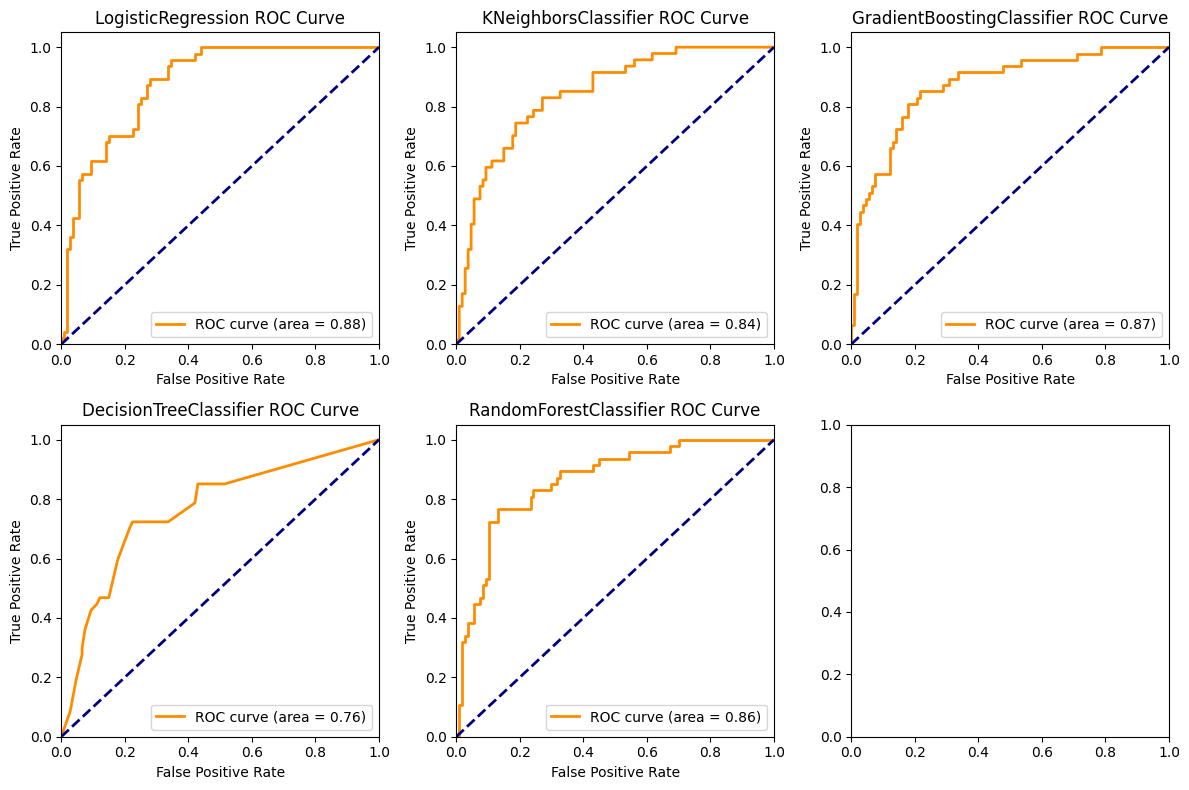

In [330]:
roc_models = [lr, knn,gb, dt, rf]  # Assuming these are your trained models

# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

for i, model in enumerate(roc_models):
       plot_roc_curve(model, X_test, y_test, ax=axes[i])
       axes[i].set_title(f"{model.__class__.__name__} ROC Curve")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

AUC Curve: This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

0.90 - 1.00 = excellent

0.80 - 0.90 = good

0.70 - 0.80 = fair

0.60 - 0.70 = poor

0.50 - 0.60 = fail

#### Best Model


In [331]:
y_pred = rf.predict(X_test)
score = accuracy_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 81.82


Difference between Actual and Predicted Values

Save Best Model in File

In [332]:
import pickle  # Import the pickle module

# Define the selected model
selected_model = rf  # select 'rf' to the best model 

# Save the selected model using pickle
pickle.dump(selected_model, open('../../../../best_model.pkl', 'wb+'))  # Dump the selected model to 'best_model.pkl' file

# Save the scaler object using pickle if applicable
pickle.dump(scaler, open('../../../../scaler.pkl', 'wb+'))  # Dump the scaler object to 'scaler.pkl' file if it's used for preprocessing